In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import scipy as sp
from scipy import interpolate
from scipy.optimize import root
import pymc
import obspy
import random
from cdh_mc import Model
from modal_sum import calc_nu, P_tl, P_tr, P_bl, P_br,F_tl, F_tr, F_bl, F_br, Pprecise_tl, Pprecise_tr, Pprecise_bl, Pprecise_br,amplifyP

# User Defined

## Define geometry

In [2]:
params_dict = { 'min_layers':3, 'max_layers':3,  'min_rho':1, 'max_rho':3, 'min_vel':1, 'max_vel':3, \
              'min_depth':0, 'max_depth':300,} # units: N/A; g/cc; km/s; km
model = Model(params_dict)
model.layer_1.mu = 2

## Define search space

In [3]:
z = model.no_layers

nk = 1000

nyquist = 1.0*(2*np.pi) # 1 hz
nw = 64
dw = nyquist/nw

w = np.arange(dw, nyquist+dw, dw)

model.layer_1.upper_interface = 0 
model.layer_1.lower_interface = 4 #h1 = 4 km
model.layer_1.h = 4
model.layer_2.upper_interface = 4 
model.layer_2.lower_interface = 29 #h2 = 25 km
model.layer_2.h = 25
# model.layer_3.upper_interface = 29
# model.layer_3.lower_interface = 129 #h3 = 100 km
# model.layer_3.h = 100

model.layer_1.velocity = 2.4*100000 # 2.4*10^5 cm/s
model.layer_2.velocity = 3.5*100000
model.layer_3.velocity = 4.5*100000
beta_max = max([model.layer_1.velocity,model.layer_2.velocity,model.layer_3.velocity])
beta_min = min([model.layer_1.velocity,model.layer_2.velocity,model.layer_3.velocity])

model.layer_1.density = 2.0 # 2 g/cm^3
model.layer_2.density = 2.67
#model.layer_3.density = 3.3

model.layer_1.mu = model.layer_1.velocity**2 * model.layer_1.density
model.layer_2.mu = model.layer_2.velocity**2 * model.layer_2.density
#model.layer_3.mu = model.layer_3.velocity**2 * model.layer_3.density

# Generate propogator matrix for top layer

In [8]:
z = model.layer_1.h * 100000 #set z thickness to be the top layer

K = np.zeros((len(w))) #preallocate for final wavenumbers, to be filled by the search
    
for wn,wi in enumerate(w): #iterate through ang. frequency
    
    kmin = wi/beta_max; #wavenumber range is changing with every frequency
    kmax = wi/beta_min;
    k = np.arange(0, kmax+kmin/nk, kmin/nk)
    B = np.zeros((len(k),2,2)) + 0j #preallocate the B matrix for this frequency with complex zeros
    
    for kn,ki in enumerate(k): #iterate through wavenumber
         
################################################################
# ALEX: implement this convention after we get it working...
#             layer = z+1
#             layer_object = getattr(model, "layer_%i" % layer)
#             beta = layer_object.velocity

        nu1 = calc_nu(ki, wi, model.layer_1.velocity); #set vertical slowness for each layer
        nu2 = calc_nu(ki, wi, model.layer_2.velocity);

        #nu3 = calc_nu(k, w, model.layer_3.velocity)

#             mu1 = model.layer_1.mu
#             mu2 = model.layer_2.mu
#             #mu3 = model.layer_3.mu

#             h1 = model.layer_1.h
#             h2 = model.layer_1.h
#             #h3 = model.layer_1.h
################################################################

        #calc F matrix
        F = (1/(2*nu2*model.layer_2.mu))*np.array([[F_tl(nu2, z, model.layer_2.mu), F_tr(nu2, z, model.layer_2.mu)],
                                              [F_bl(nu2, z, model.layer_2.mu), F_br(nu2, z, model.layer_2.mu)]])

        #calc P matrix
        P = np.array([[P_tl(nu1, z), P_tr(nu1, z, model.layer_1.mu)],
                      [P_bl(nu1, z, model.layer_1.mu), P_br(nu1, z)]]);
#         P = np.array([[Pprecise_tl(nu1, z), Pprecise_tr(nu1, z, model.layer_1.mu)],
#                       [Pprecise_bl(nu1, z, model.layer_1.mu), Pprecise_br(nu1, z)]]);
    
        
#         P = amplifyP(P,nu1,model.layer_1.mu)

#         print(P)
        
        #fill B matrix
        B[kn] = np.matmul(F,P) #equivalent to * in matlab

#         print(B)
    B21 = np.real(B[:,1,0]) #grab the B21 component of B, which is a 1 x k vector now
    
    IB21 = np.imag(B[:,1,0]) #find where B21 goes real
    J = np.where(IB21 == 0)[0]
    A = B21[J] 
    
    L = np.where(np.abs(A) < 0.01) #find a real, stable minimum value of B21
    K[wn] = np.max(k[J[L]]) #retrieve the wavenumber associated with this value

In [9]:
#phase velocity
c=w/K;

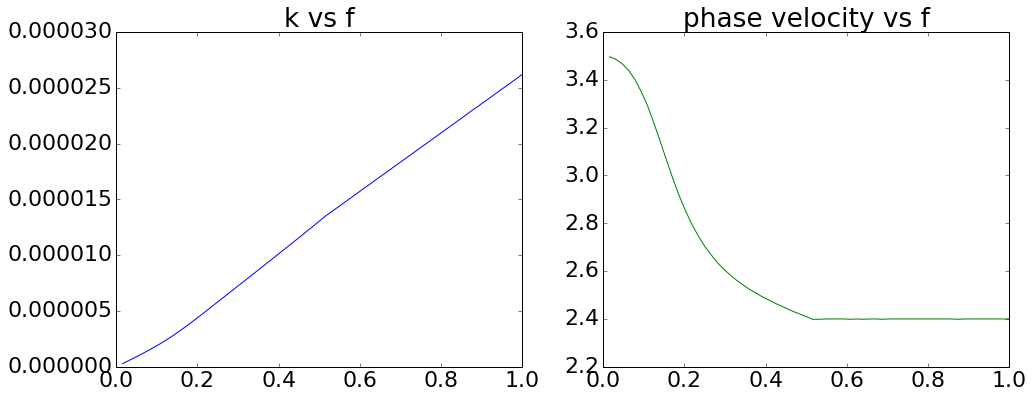

In [44]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(w/(2*np.pi),K)
ax[0].set_title('k vs f')

ax[1].plot(w/(2*np.pi),c/100000,'g-')
ax[1].set_title('phase velocity vs f');


plt.rcParams.update({'font.size': 22})

# Calculate L1 and L2 stress-motion vectors by propogator matrix for each k

In [47]:
z=np.arange(0,41,1)*100000;

L1 = np.zeros(np.shape(z)) + 0j
L2 = np.zeros(np.shape(z)) + 0j

ki = K[9];
wi = w[9];

for zn,zi in enumerate(z): #start from the top
    
    nu = calc_nu(ki, wi, [model.layer_1.velocity,model.layer_2.velocity,model.layer_3.velocity]); #vert. slownesses

    if zi <= model.layer_1.h*100000: #still inside the first layer
        P = np.array([[P_tl(nu[0], zi), P_tr(nu[0], zi, model.layer_1.mu)],
                      [P_bl(nu[0], zi, model.layer_1.mu), P_br(nu[0], zi)]]);

    if zi > model.layer_1.h*100000: #now inside the 2nd layer
        z0=model.layer_1.h*100000; #need to now think of z as the distance from the bottom of the first layer
        P1 = np.array([[P_tl(nu[1], (zi-z0)), P_tr(nu[1], (zi-z0), model.layer_2.mu)],
                      [P_bl(nu[1], (zi-z0), model.layer_2.mu), P_br(nu[1], (zi-z0))]]);
        
        P = np.matmul(P1,np.array([[P_tl(nu[0], z0), P_tr(nu[0], z0, model.layer_1.mu)],
                      [P_bl(nu[0], z0, model.layer_1.mu), P_br(nu[0], z0)]]));

    L1[zn] = P[0,0];
    L2[zn] = P[1,0];

/Applications/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


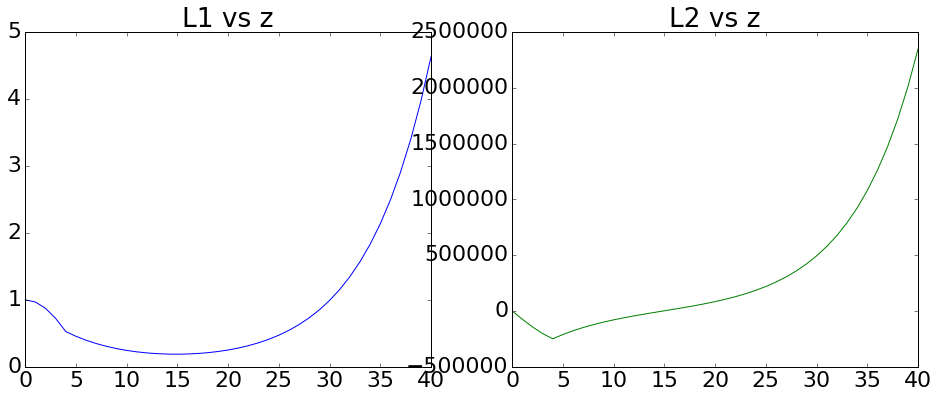

In [50]:
fig,ax = plt.subplots(1,2,figsize=(16,6));
ax[0].plot(z/100000,L1);
ax[0].set_title('L1 vs z');

ax[1].plot(z/100000,L2,'g-');
ax[1].set_title('L2 vs z');


plt.rcParams.update({'font.size': 22})

In [91]:
z=np.arange(0,41,1)*100000;

L1 = np.zeros((len(z),len(K))) + 0j
L2 = np.zeros((len(z),len(K))) + 0j

ki = K[4];
wi = w[4];

for zn,zi in enumerate(z): #start from the top
    
    for i in range(len(K)):
        nu = calc_nu(K[i], w[i], [model.layer_1.velocity,model.layer_2.velocity,model.layer_3.velocity]); #vert. slownesses

        if zi <= model.layer_1.h*100000: #still inside the first layer
            P = np.array([[Pprecise_tl(nu[0], zi), Pprecise_tr(nu[0], zi, model.layer_1.mu)],
                          [Pprecise_bl(nu[0], zi, model.layer_1.mu), Pprecise_br(nu[0], zi)]]);
#             P = np.array([[P_tl(nu[0], zi), P_tr(nu[0], zi, model.layer_1.mu)],
#                           [P_bl(nu[0], zi, model.layer_1.mu), P_br(nu[0], zi)]]);



        if zi > model.layer_1.h*100000: #now inside the 2nd layer
            z0=model.layer_1.h*100000; #need to now think of z as the distance from the bottom of the first layer
            P1 = np.array([[Pprecise_tl(nu[1], (zi-z0)), Pprecise_tr(nu[1], (zi-z0), model.layer_2.mu)],
                          [Pprecise_bl(nu[1], (zi-z0), model.layer_2.mu), Pprecise_br(nu[1], (zi-z0))]]);

            P = np.matmul(P1,np.array([[Pprecise_tl(nu[0], z0), Pprecise_tr(nu[0], z0, model.layer_1.mu)],
                          [Pprecise_bl(nu[0], z0, model.layer_1.mu), Pprecise_br(nu[0], z0)]]));

            
        P = amplifyP(P,nu[0],zi)

        L1[zn,i] = P[0,0];
        L2[zn,i] = P[1,0];

/Applications/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


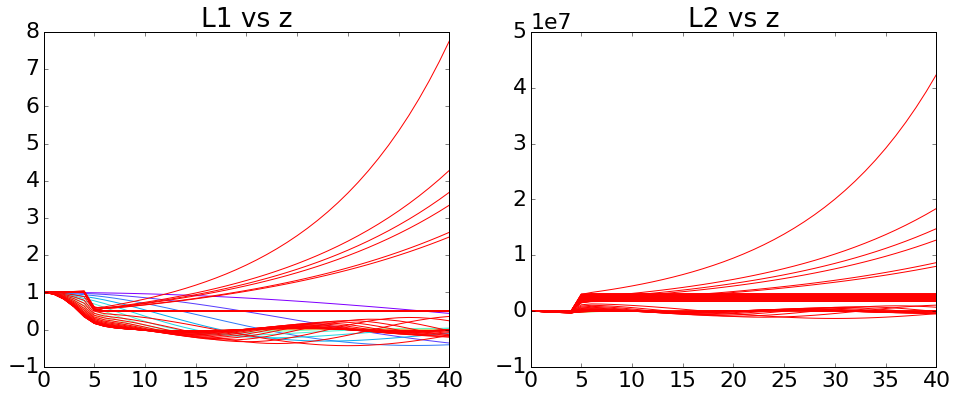

In [98]:
import matplotlib.cm as cm
cmap = cm.get_cmap('rainbow')


fig,ax = plt.subplots(1,2,figsize=(16,6));
for i in range(len(K)):
    c=cmap(20*i)
    ax[0].plot(z/100000,L1[:,i],color=c);
    ax[0].set_title('L1 vs z');

for i in range(len(K)):
    c=cmap(20*i)
    ax[1].plot(z/100000,L2[:,i],color=c);
    ax[1].set_title('L2 vs z',);

plt.rcParams.update({'font.size': 22})
